<a href="https://colab.research.google.com/github/thinkGrow/Neural-Network-CSC424/blob/main/nn_4_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt     
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
x_train = trainset.data
x_test = testset.data
y_train = np.array(trainset.targets)
y_test = np.array(testset.targets)

dimension_two = x_train.shape[1]*x_train.shape[2]*x_train.shape[3] #3072 from 50,000x32x32x3

x_train = x_train.reshape(x_train.shape[0], dimension_two) #50,000 x 3072
x_test = x_test.reshape(x_test.shape[0], dimension_two) #50,000 x 3072

x_train = x_train/255
x_test = x_test/255

no_of_train_sample = x_train.shape[0]

print(y_train.shape)

(50000,)


In [ ]:
def loss(y_train, z1, w):
    #score = output of the last layer
    norm = torch.sum(torch.square(w))
    # y_train = y_train.reshape(50000, 10)    
    zeros = torch.zeros(50000, 10)
    mx = torch.maximum(zeros, z1 - z1.gather(-1, y_train.long()) + 1) #Formula: Loss = max(0,predicted-original+1)  
    
    return (1/y_train.shape[0]) * (torch.sum(mx)) + norm


def hinge_grad_input(y_pred, y_train): #ao, y_train
    grad_input = np.where(y_pred * y_train < 1, -y_train / y_train.size, 0)
    #the gradient equals -y/N for all the cases where y*y < 1, otherwise 0.
    return grad_input


def xavier_initializer(fan_in, fan_out) :
    limit = math.sqrt(6/(fan_in + fan_out))

    fan_in_o = 4000
    fan_out_o = 1
    limit_o = math.sqrt(6/(fan_in_o + fan_out_o))

    return np.random.uniform(-limit, limit, size=(fan_in, fan_out))

def ohe(to_encode):
    ohe = np.zeros((to_encode.shape[0],10))
    for i in range(to_encode.shape[0]):
        for j in range(10):
            if to_encode[i] == j:
                ohe[i][j] = 1 
    return ohe

def conclusion(y_test_ohe, y_predict_ohe):

    # print("Confusion Matrix: \n", confusion_matrix(y_test, y_predict), "\n")
    print("Accuracy: ", accuracy_score(y_test_ohe, y_predict_ohe), "\n")
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']   

    ax= plt.subplot()

    cm = confusion_matrix(np.asarray(y_test_ohe).argmax(axis=1), np.asarray(y_predict_ohe).argmax(axis=1))
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
    # print("F-score:\n", f1_score(y_test, y_predict, average = None), "\n")

In [ ]:
y_train = ohe(y_train)
y_test = ohe(y_test)
print(x_train.shape)
print(y_train.shape)

(50000, 3072)
(50000, 10)


In [ ]:
class NeuralNetwork:
    def __init__(self):
        self.w1 = xavier_initializer(3072,10)
        self.b1 = np.random.randn(10)
        self.lr = 0.001
        self.z1 = np.empty((3072,10))
        self.loss = 0
        self.loss_epoch_temp = 0.0

        self.batch_size = 1000
    
    def feedforward(self, x_batch):
        # Phase 1
        self.z1 = np.dot(x_batch, self.w1) + self.b1
        return self.z1


    def backprop(self, x_train, y_train):
        ## Back Propagation
        
        #Phase 1
        dL_dz1 = hinge_grad_input(self.z1,y_train)
        dL_dw1 = np.dot(x_train.T, dL_dz1)

        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)

        # Update Weights 

        self.w1 -= self.lr * dL_dw1
        self.b1 -= self.lr * dL_db1.sum(axis=0)

        self.w1 = torch.from_numpy(self.w1).float()
        self.z1 = torch.from_numpy(self.z1).float()
        y_train = torch.from_numpy(y_train).float()
        self.loss = loss(y_train, self.z1, self.w1)
        self.loss = self.loss.numpy()
        self.w1 = self.w1.numpy()
        self.z1 = self.z1.numpy()
        # print(self.w1)
        # self.loss = self.loss.item()
        # print(self.loss.dtype)

        # self.loss_epoch_temp += loss



    def train(self, x_train, y_train) :
        loss = 0.0
        for epoch in range(10):


            self.feedforward(x_train)
            self.backprop(x_train,y_train)
            print('Loss of batch ', epoch+1, ": ",  self.loss)

            # print(f'epoch no. {epoch+1} : {self.loss_epoch_temp}') 
            self.loss_epoch_temp = 0

In [ ]:
nn = NeuralNetwork()
nn.train(x_train,y_train)
y_predict = nn.feedforward(x_test)

Loss of batch  1 :  24.612846
Loss of batch  2 :  24.612518
Loss of batch  3 :  24.612211
Loss of batch  4 :  24.611908
Loss of batch  5 :  24.611614
Loss of batch  6 :  24.611332
Loss of batch  7 :  24.611065
Loss of batch  8 :  24.610811
Loss of batch  9 :  24.610567
Loss of batch  10 :  24.610342


In [ ]:
index = np.argmax(y_predict, axis=1)
y_predict_ohe = np.zeros((10000,10))
for i in range(10000):    
    for j in range(10):
        if j == index[i]:
              y_predict_ohe[i][index[i]]= 1
        else: y_predict_ohe[i][j]=0 

Accuracy:  0.1104 



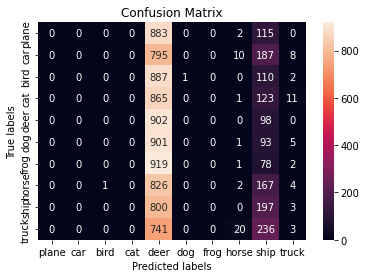

In [ ]:
conclusion(y_test, y_predict_ohe)